In [2]:
cd /home

/home


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model, build_classifier
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

In [7]:
root = './presentation/results/paper/'
adam_op = Adam(1e-5, 
               beta_1=0.9, 
               beta_2=0.98, 
#                clipvalue=1e-4,
               epsilon=1e-9)
astromer, config = load_pt_model(os.path.join(root, 'pretraining'), optimizer=adam_op)

pd.DataFrame([config])[['data', 'arch', 'lr', 'probed', 'rs', 'mask_format', 'm_alpha', 'dropout']]

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


2024-07-02 20:23:05,996 - WARNING - Inconsistent references when loading the checkpoint into this object graph. For example, in the saved checkpoint object, `model.layer.weight` and `model.layer_copy.weight` reference the same variable, while in the current object these are two different variables. The referenced variables are:(<src.models.astromer_0.Encoder object at 0x7fa8ac44f310> and <src.models.astromer_0.RegLayer object at 0x7fa8ac38f310>).


,data,arch,lr,probed,rs,mask_format,m_alpha,dropout
0,./data/records/macho/,zero,0.001,0.5,0.2,QK,1.0,0.0


In [8]:
# import glob
# data_path = glob.glob(os.path.join('./data/records/atlas', '*', '*'))
# for d in data_path:
#     old = os.path.join(d, 'val')
#     new = os.path.join(d, 'validation')
#     os.rename(old, new)
config['bs']

2500

## Loading downstream data

In [9]:
data_path = './data/records/atlas/fold_0/atlas_500/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=1024,
                       clf_mode=False,
                       sampling=False,
                       normalize='zero-mean',
                       old_version=True,
                       return_test=True)

[INFO] Using old dataloader
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [11]:
test_loss, test_r2, test_rmse, _ = astromer.evaluate(loaders['test'].take(10))
# test_loss, test_p, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

4/4 [==============================] - 1s 103ms/step - loss: 0.2360 - r_square: 0.7076 - rmse: 0.2360


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
test_r2, test_rmse

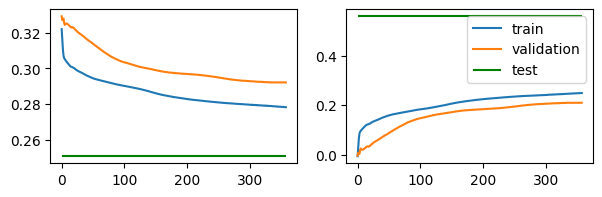

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2))
for sset in ['train', 'validation']:
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset)) 
    axes[0].plot(m['step'], m['value'])
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset), metric_name='epoch_r_square') 
    axes[1].plot(m['step'], m['value'], label=sset)

axes[0].hlines(test_loss, 0, m['step'].max(), color='g', label='test')
axes[1].hlines(test_r2, 0, m['step'].max(), color='g', label='test')
plt.legend()
plt.show()

## Finetuning

In [5]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [6]:
from src.training.utils import train
import shutil

In [24]:
TARGET = './presentation/results/dani/2024-05-14_18-41-21/'
# os.makedirs(TARGET)
# shutil.copyfile(os.path.join(root, 'pretraining', 'config.toml'), 
#                 os.path.join(TARGET, 'config.toml'))

In [ ]:
cbks = [EarlyStopping(monitor='val_loss', patience=20),
        ModelCheckpoint(filepath=os.path.join(TARGET, 'weights'),
                        save_weights_only=True,
                        save_best_only=True,
                        save_freq='epoch',
                        verbose=1)]
    
# Finetune model
hist = astromer.fit(loaders['train'], 
                        batch_size=1024,
                        epochs=10000, 
                        validation_data=loaders['validation'],
                        callbacks=cbks)
        
# astromer = train(astromer, 
#                  loaders['train'], 
#                  loaders['validation'], 
#                  exp_path=TARGET,
#                  epochs=10000)

In [14]:
astromer.load_weights('./presentation/results/dani/2024-05-14_18-41-21/weights')

In [15]:
test_loss, test_p, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

4/4 [==============================] - 2s 278ms/step - loss: 0.2518 - r_square: 0.5620 - rmse: 0.2518 - p: 0.7638


NameError: name 'hist' is not defined

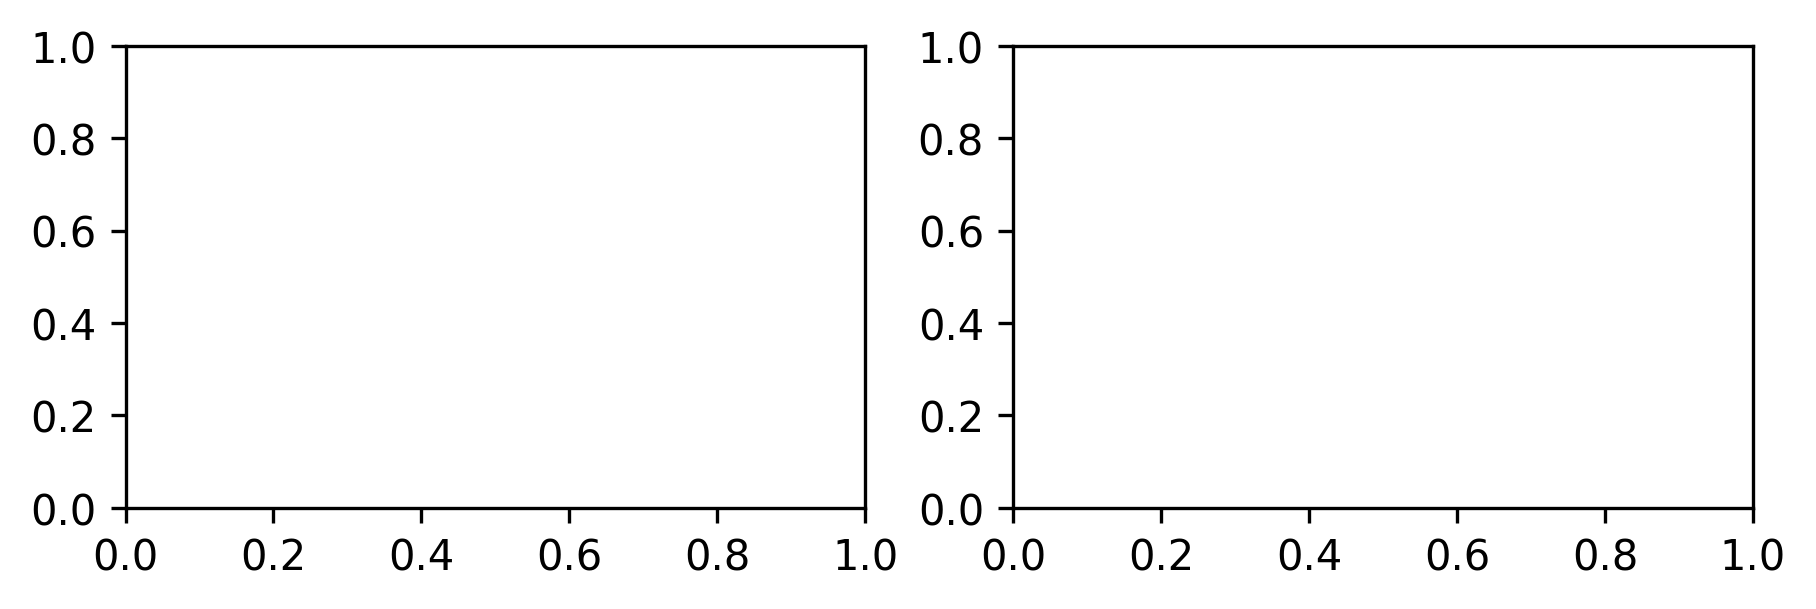

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2), dpi=300)
axes[0].plot(hist.history['loss'], label='train')
axes[0].plot(hist.history['val_loss'], label='validation')
axes[1].plot(hist.history['r_square'], label='train')
axes[1].plot(hist.history['val_r_square'], label='validation')
    
axes[0].hlines(test_loss, 0, len(hist.history['loss']), color='g', label='test')
axes[1].hlines(test_r2, 0, len(hist.history['loss']), color='g', label='test')
axes[0].legend()
axes[1].set_ylim(0, 1)
plt.show()

## Classification

In [17]:
from presentation.pipelines.steps.utils import train_classifier, predict_clf

In [18]:
data_path = './data/records/atlas/fold_0/atlas_500/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=1024,
                       clf_mode=True,
                       sampling=False,
                       normalize='zero-mean',
                       old_version=False,
                       return_test=True)

Classification Mode
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking


In [19]:
# for x, y in loaders['train'].take(1):
#     print(x['mask_in'])

In [27]:
adam_op = Adam(1e-3, 
               beta_1=0.9, 
               beta_2=0.98, 
               epsilon=1e-9)

astromer, config = load_pt_model('./presentation/results/dani/2024-05-14_18-41-21/', optimizer=adam_op)

[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only


In [28]:
clf = build_classifier(astromer, 
                         config, 
                         astromer_trainable=False, 
                         num_cls=loaders['n_classes'], 
                         arch='avg_mlp')

[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Using avg_mlp clf architecture with base


In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

In [30]:
target_dir = os.path.join('./presentation/results/test')
optimizer = Adam(learning_rate=1e-3)
os.makedirs(target_dir, exist_ok=True)

clf.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

estop = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=20,
                      verbose=0,
                      mode='auto',
                      baseline=None,
                      restore_best_weights=True)
tb = TensorBoard(log_dir=os.path.join(target_dir, 'logs'),
                 write_graph=False,
                 write_images=False,
                 update_freq='epoch',
                 profile_batch=0,
                 embeddings_freq=0,
                 embeddings_metadata=None)

hist = clf.fit(loaders['train'],
              epochs=10000,
              batch_size=512,
              callbacks=[estop, tb],
              validation_data=loaders['validation'])

Epoch 1/10000
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only


2024-05-28 20:57:26.575323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-05-28 20:57:26.615484: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9d2ceccb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 20:57:26.615516: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-05-28 20:57:26.620214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 20:57:26.744993: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      3/Unknown - 4s 126ms/step - loss: 3.7284 - accuracy: 0.1951[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 6s 729ms/step - loss: 3.7284 - accuracy: 0.1951 - val_loss: 3.8342 - val_accuracy: 0.1954
Epoch 2/10000
3/3 [==============================] - 1s 392ms/step - loss: 3.3900 - accuracy: 0.1994 - val_loss: 1.9998 - val_accuracy: 0.1973
Epoch 3/10000
3/3 [==============================] - 1s 381ms/step - loss: 1.9712 - accuracy: 0.2066 - val_loss: 1.7976 - val_accuracy: 0.2012
Epoch 4/10000
3/3 [==============================] - 1s 385ms/step - loss: 1.7976 - accuracy: 0.1994 - val_loss: 1.7657 - val_accuracy: 0.1992
Epoch 5/10000
3/3 [==============================] - 1s 377ms/step - loss: 1.7246 - accuracy: 0.1989 - val_loss: 1.5864 - val_accuracy: 0.3385
Epoch 6/10000
3/3 [==============================] - 1s 391ms/step - loss: 1.5929 - accuracy: 0.3404 - val_loss: 1.6457 - val_accuracy: 0.3017
Epoch 7/10000
3/3 [========

In [ ]:
scores = predict_clf(clf, loaders['test'])

In [ ]:
'{:.2f}'.format(scores['f1'])